<a href="https://colab.research.google.com/github/FKz11/Neural_Network/blob/main/lesson_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# lesson-8

## 1) Обучите GAN на одном классе CIFAR. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.

## Библиотеки

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

## Загрузим данные

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])

170508288/170498071 [==============================] - 3s 0us/step


In [ ]:
x.shape

(60000, 32, 32, 3)

## Преобразуем данные

In [ ]:
n_class = 1

In [ ]:
x = x[np.where(y == n_class)[0]] # Возьмём только один класс, первый

In [ ]:
x.shape

(6000, 32, 32, 3)

In [ ]:
batch_size = 64
prefetch_size = 32

In [ ]:
x_train = (x.astype("float32") - 127.5) / 127.5 # Приведём данные в удобный для нн вид, от -1 до 1
x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_train = x_train.batch(batch_size).prefetch(prefetch_size)

## Пример изображение

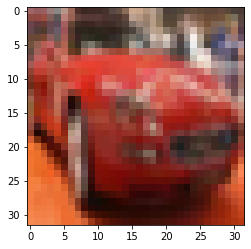

In [ ]:
plt.imshow(x[1])
plt.show()

## Строим discriminator

Проверят, настоящее изображение или сгенерированное

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),
        layers.Conv2D(64, (3, 3), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_47 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_30 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_49 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_32 (Conv2D)          (None, 4, 4, 256)       

## Строим generator

Определимся с размерностью латентного вектора, который будет определять сгенерированное изображение

In [ ]:
latent_dim = 100

In [ ]:
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # строим размер входного вектора 4x4x256 map
        layers.Dense(4 * 4 * 256),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((4, 4, 256)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (3, 3), padding="same", activation="tanh"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 4096)              413696    
                                                                 
 leaky_re_lu_55 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_7 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 8, 8, 128)        524416    
 Transpose)                                                      
                                                                 
 leaky_re_lu_56 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_22 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                              

## Прописываем процесс обучения GAN модели

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):

        # берем случайные векторы
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Строим по ним фейковое изображение
        generated_images = self.generator(random_latent_vectors)

        # собираем с реальными в тензор
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # задаем метки 1 и 0 соответственно
        # к метки 1 добовляем шум, чтобы gan сходился
        labels = tf.concat(
            [tf.random.normal((batch_size, 1), mean=0.95, stddev=0.05), 
             tf.zeros((batch_size, 1))], axis=0
        )

        # учим discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # берем случайные векторы
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # метки реальных изображений
        misleading_labels = tf.zeros((batch_size, 1))

        # Учим generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

## Callback для вывода изображений по ходу обучения

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, latent_dims, num_img=3):
        self.num_img = num_img
        self.latent_dims = latent_dims

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = self.latent_dims
        generated_images = self.model.generator(random_latent_vectors)
        image = generated_images.numpy()
        plt.figure(figsize = (self.num_img*4, 4))
        for i in range(self.num_img):
          plt.subplot(1,self.num_img,i+1)
          plt.imshow((image[i] + 1) / 2)
        plt.show()

## Учим модель

In [ ]:
epochs = 100

In [ ]:
num_img = 3
test_latent_dims = tf.random.normal(shape=(num_img, latent_dim))

Epoch 1/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.4144 - g_loss: 1.2546

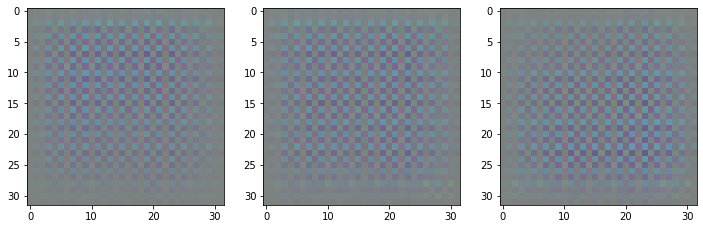

94/94 [==============================] - 6s 55ms/step - d_loss: 0.4090 - g_loss: 1.2679
Epoch 2/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.3643 - g_loss: 3.0400

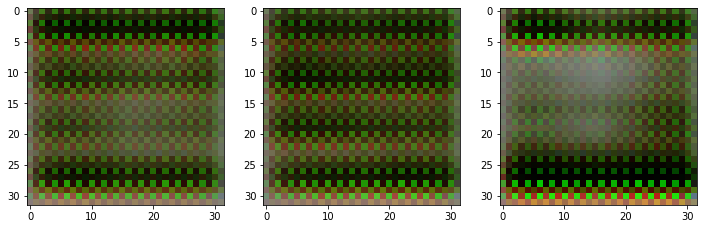

94/94 [==============================] - 5s 55ms/step - d_loss: 0.3658 - g_loss: 3.0227
Epoch 3/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.3748 - g_loss: 1.9385

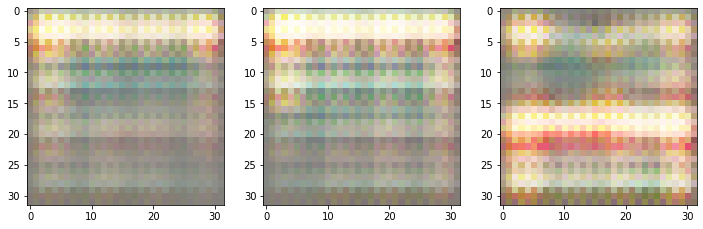

94/94 [==============================] - 5s 56ms/step - d_loss: 0.3766 - g_loss: 1.9587
Epoch 4/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.3507 - g_loss: 2.1486

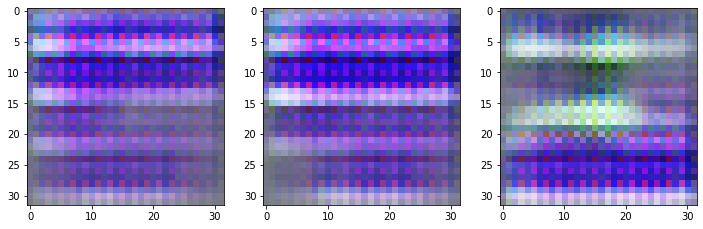

94/94 [==============================] - 5s 56ms/step - d_loss: 0.3482 - g_loss: 2.1801
Epoch 5/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.4376 - g_loss: 2.0384

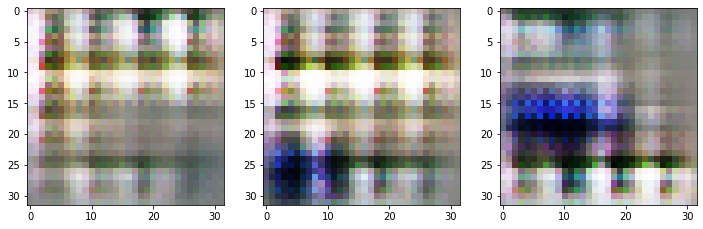

94/94 [==============================] - 5s 56ms/step - d_loss: 0.4349 - g_loss: 2.0474
Epoch 6/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.4788 - g_loss: 1.6763

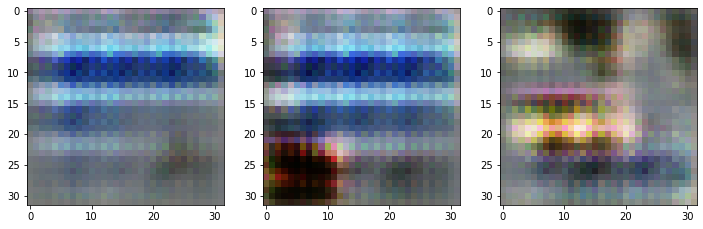

94/94 [==============================] - 5s 56ms/step - d_loss: 0.4795 - g_loss: 1.6652
Epoch 7/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5132 - g_loss: 1.5213

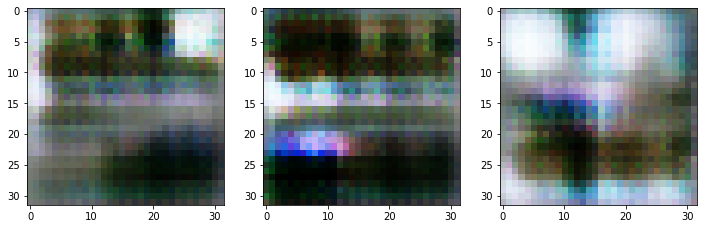

94/94 [==============================] - 5s 55ms/step - d_loss: 0.5127 - g_loss: 1.5219
Epoch 8/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5213 - g_loss: 1.5457

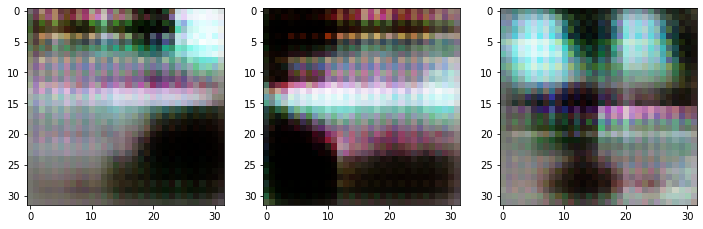

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5233 - g_loss: 1.5358
Epoch 9/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5291 - g_loss: 1.3260

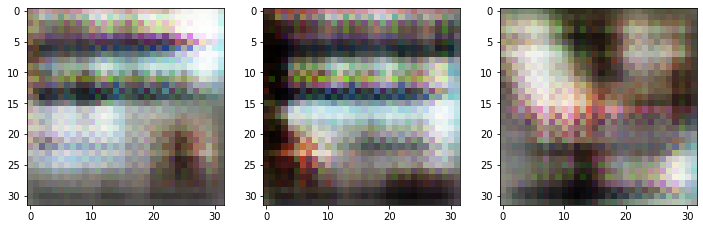

94/94 [==============================] - 5s 55ms/step - d_loss: 0.5321 - g_loss: 1.3307
Epoch 10/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5792 - g_loss: 1.1637

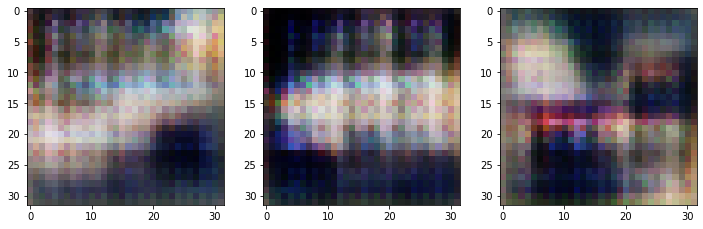

94/94 [==============================] - 5s 54ms/step - d_loss: 0.5791 - g_loss: 1.1657
Epoch 11/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5451 - g_loss: 1.4048

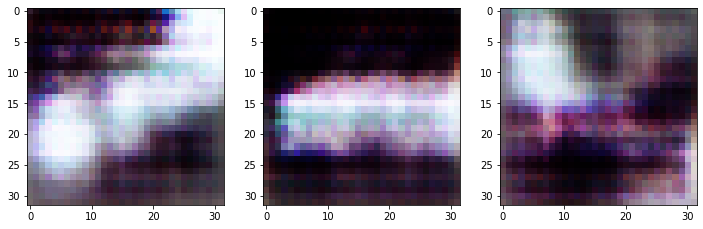

94/94 [==============================] - 5s 57ms/step - d_loss: 0.5442 - g_loss: 1.4022
Epoch 12/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5266 - g_loss: 1.3249

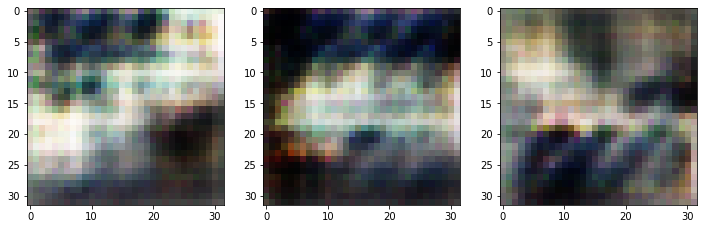

94/94 [==============================] - 5s 54ms/step - d_loss: 0.5252 - g_loss: 1.3215
Epoch 13/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5687 - g_loss: 1.3211

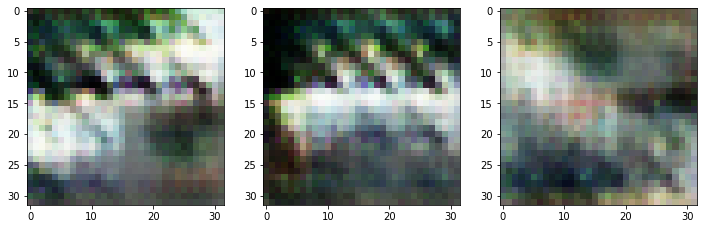

94/94 [==============================] - 5s 55ms/step - d_loss: 0.5683 - g_loss: 1.3168
Epoch 14/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5852 - g_loss: 1.3317

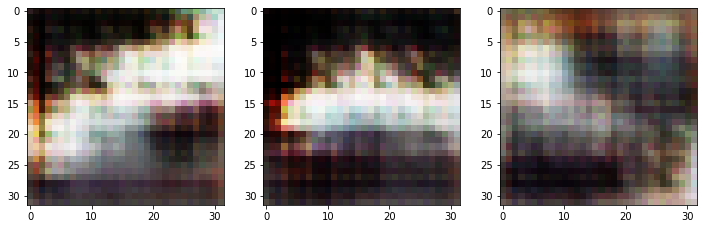

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5832 - g_loss: 1.3326
Epoch 15/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5536 - g_loss: 1.2938

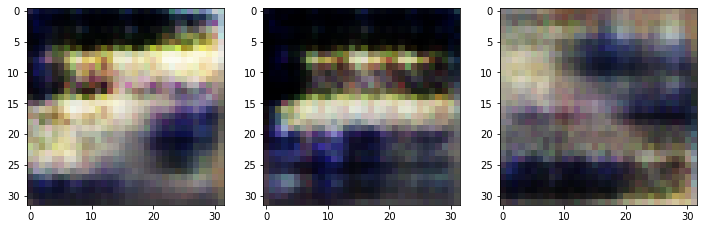

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5550 - g_loss: 1.2875
Epoch 16/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5647 - g_loss: 1.1530

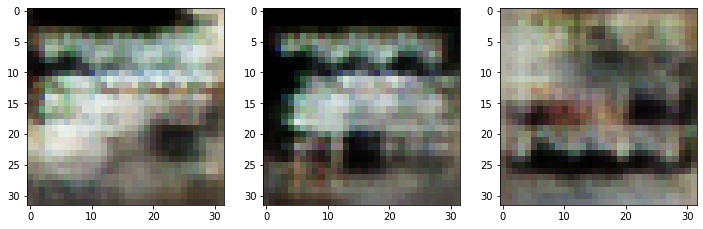

94/94 [==============================] - 5s 57ms/step - d_loss: 0.5639 - g_loss: 1.1534
Epoch 17/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5678 - g_loss: 1.3698

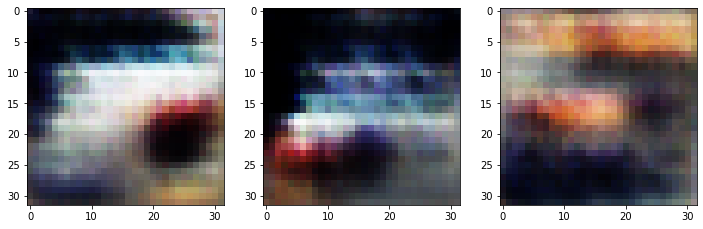

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5665 - g_loss: 1.3736
Epoch 18/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5434 - g_loss: 1.3296

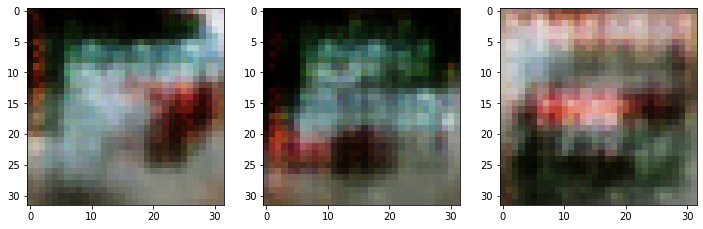

94/94 [==============================] - 5s 55ms/step - d_loss: 0.5428 - g_loss: 1.3219
Epoch 19/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5473 - g_loss: 1.2899

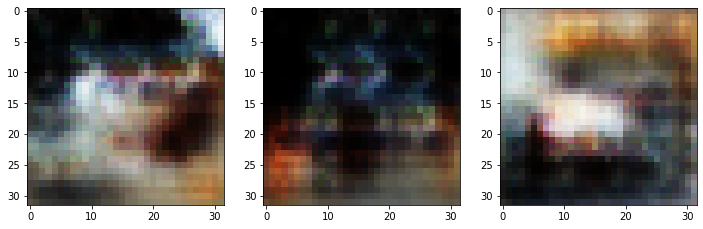

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5464 - g_loss: 1.2836
Epoch 20/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5578 - g_loss: 1.4252

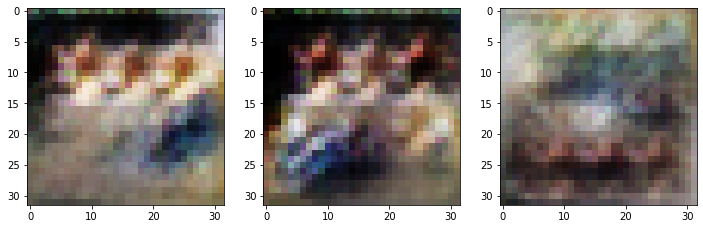

94/94 [==============================] - 5s 55ms/step - d_loss: 0.5581 - g_loss: 1.4234
Epoch 21/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5531 - g_loss: 1.3233

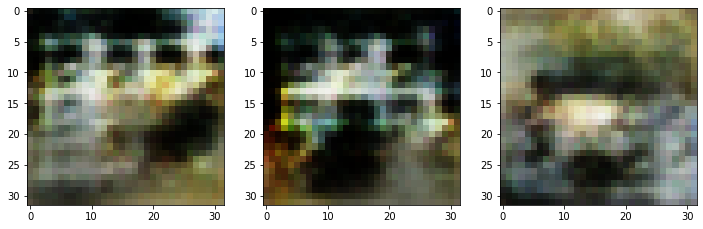

94/94 [==============================] - 5s 55ms/step - d_loss: 0.5518 - g_loss: 1.3299
Epoch 22/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5283 - g_loss: 1.3145

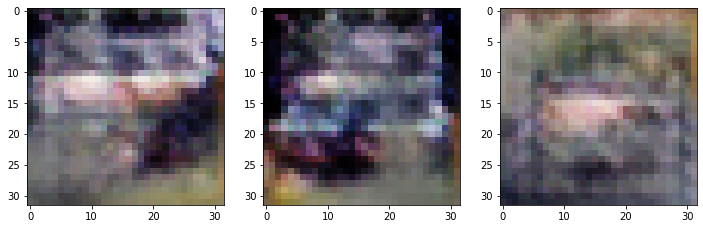

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5260 - g_loss: 1.3193
Epoch 23/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5116 - g_loss: 1.5528

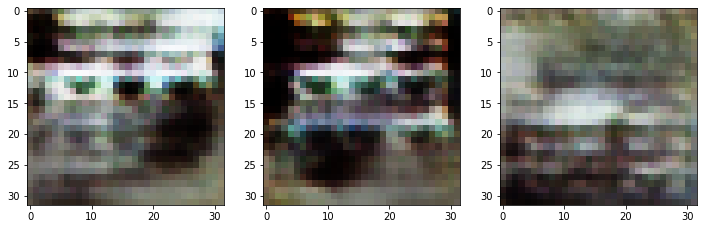

94/94 [==============================] - 5s 55ms/step - d_loss: 0.5093 - g_loss: 1.5743
Epoch 24/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5146 - g_loss: 1.5789

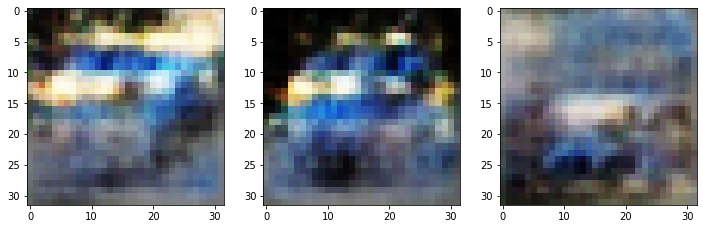

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5175 - g_loss: 1.5873
Epoch 25/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.4806 - g_loss: 1.4637

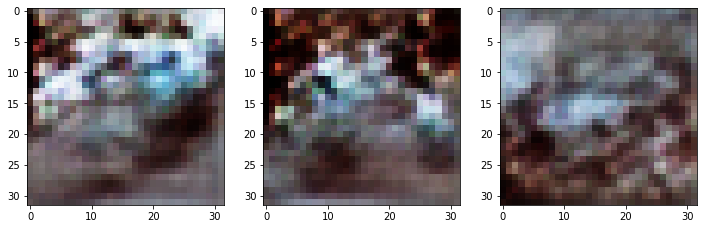

94/94 [==============================] - 5s 58ms/step - d_loss: 0.4808 - g_loss: 1.4637
Epoch 26/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5200 - g_loss: 1.4218

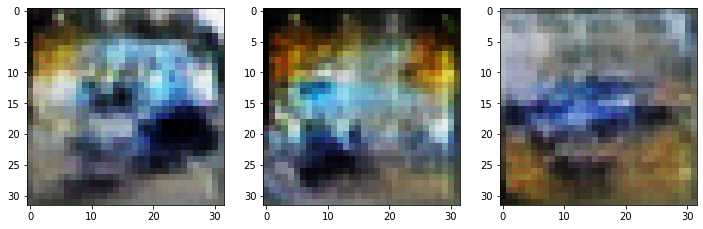

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5216 - g_loss: 1.4214
Epoch 27/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5142 - g_loss: 1.4148

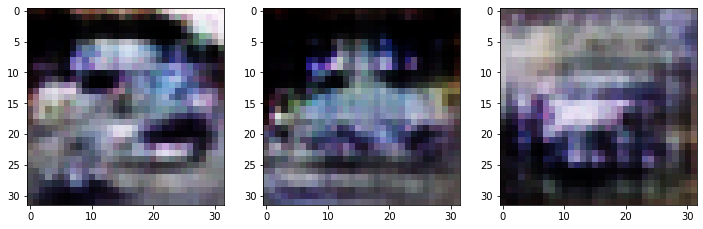

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5155 - g_loss: 1.4137
Epoch 28/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5077 - g_loss: 1.3391

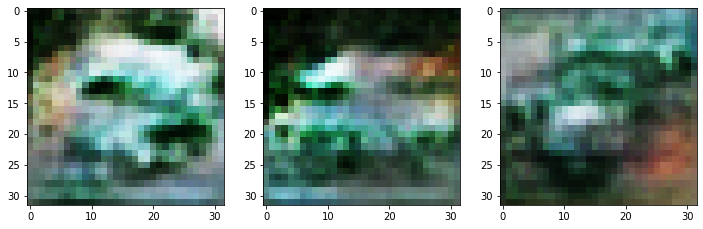

94/94 [==============================] - 5s 57ms/step - d_loss: 0.5066 - g_loss: 1.3366
Epoch 29/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5224 - g_loss: 1.3130

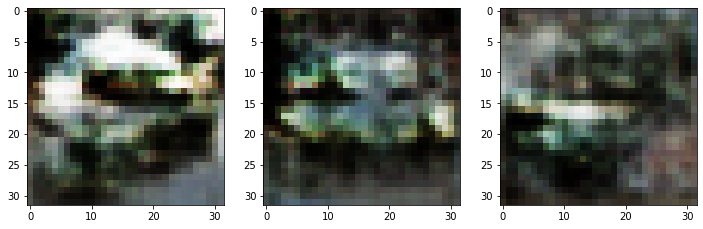

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5198 - g_loss: 1.3186
Epoch 30/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5225 - g_loss: 1.3392

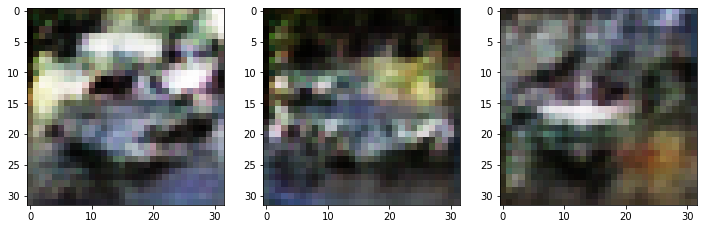

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5210 - g_loss: 1.3354
Epoch 31/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5201 - g_loss: 1.3114

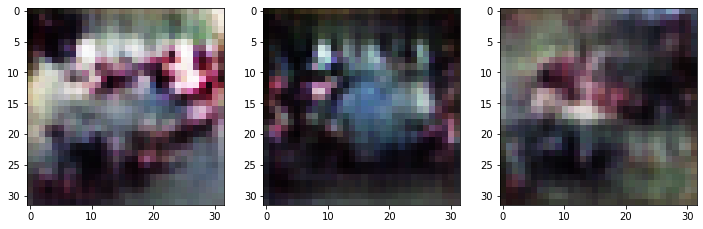

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5196 - g_loss: 1.3052
Epoch 32/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5104 - g_loss: 1.2640

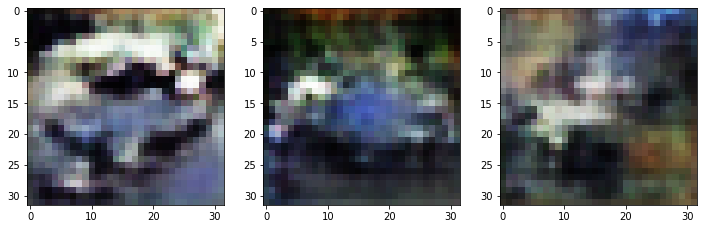

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5098 - g_loss: 1.2571
Epoch 33/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5228 - g_loss: 1.2545

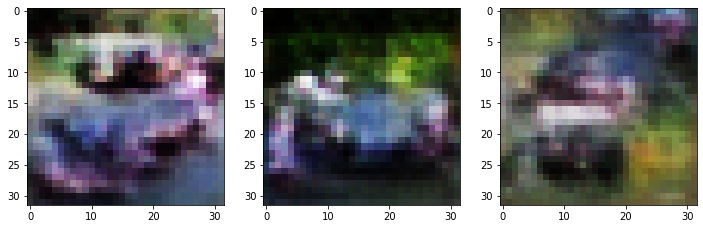

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5230 - g_loss: 1.2518
Epoch 34/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5252 - g_loss: 1.2898

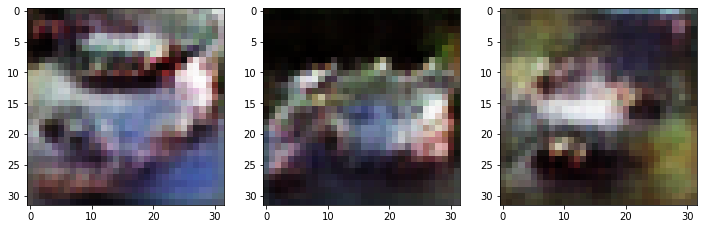

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5243 - g_loss: 1.2980
Epoch 35/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5250 - g_loss: 1.2977

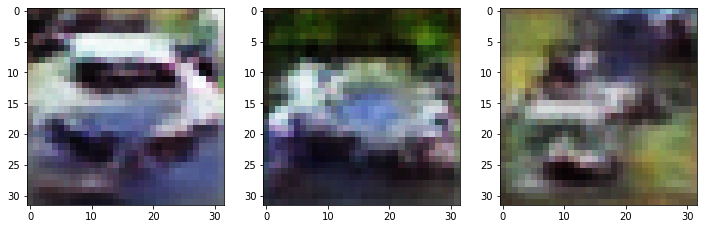

94/94 [==============================] - 5s 55ms/step - d_loss: 0.5250 - g_loss: 1.2973
Epoch 36/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5051 - g_loss: 1.3327

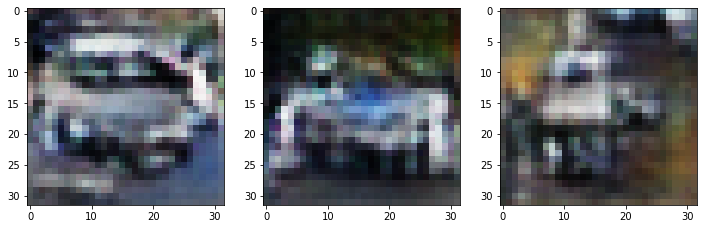

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5047 - g_loss: 1.3369
Epoch 37/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5017 - g_loss: 1.4060

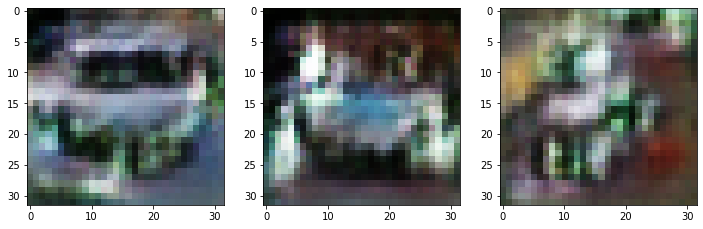

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5014 - g_loss: 1.4145
Epoch 38/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.4959 - g_loss: 1.3592

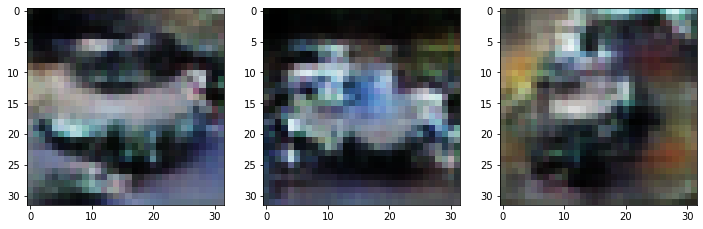

94/94 [==============================] - 5s 55ms/step - d_loss: 0.4947 - g_loss: 1.3732
Epoch 39/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5193 - g_loss: 1.3302

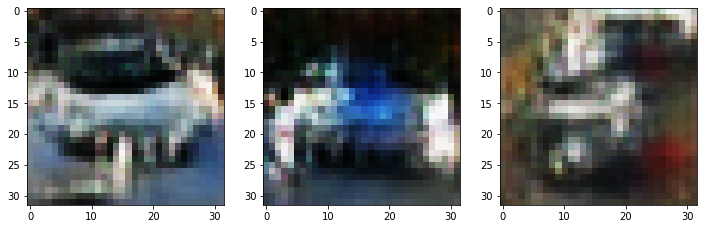

94/94 [==============================] - 5s 58ms/step - d_loss: 0.5191 - g_loss: 1.3298
Epoch 40/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5119 - g_loss: 1.2719

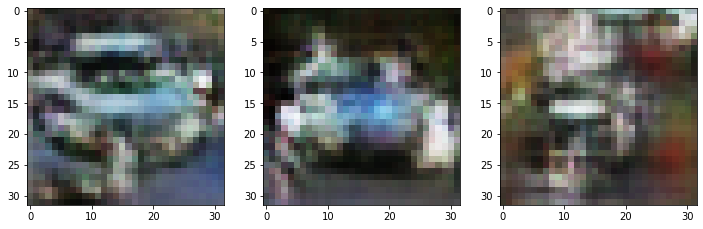

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5120 - g_loss: 1.2738
Epoch 41/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5227 - g_loss: 1.2299

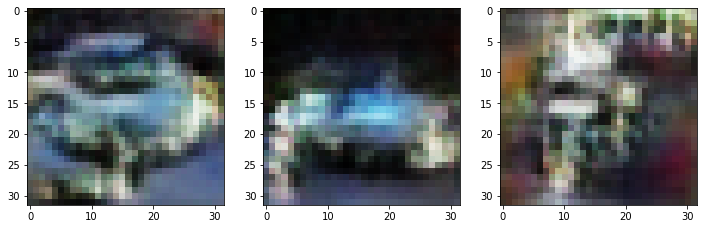

94/94 [==============================] - 5s 55ms/step - d_loss: 0.5218 - g_loss: 1.2266
Epoch 42/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5157 - g_loss: 1.2223

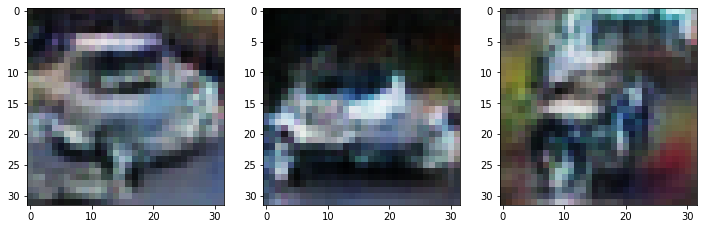

94/94 [==============================] - 5s 55ms/step - d_loss: 0.5158 - g_loss: 1.2270
Epoch 43/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5252 - g_loss: 1.2158

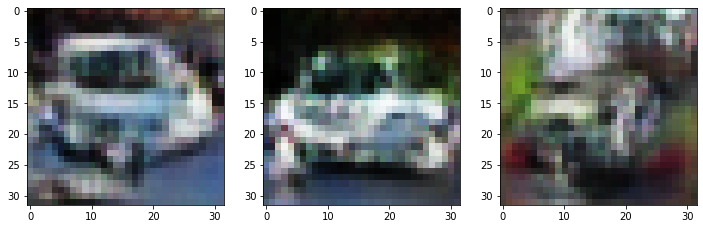

94/94 [==============================] - 5s 55ms/step - d_loss: 0.5240 - g_loss: 1.2159
Epoch 44/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5206 - g_loss: 1.2274

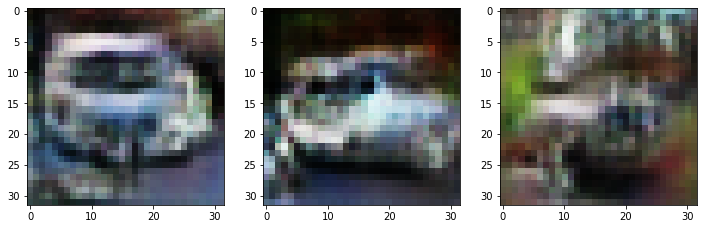

94/94 [==============================] - 5s 55ms/step - d_loss: 0.5200 - g_loss: 1.2272
Epoch 45/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5248 - g_loss: 1.2597

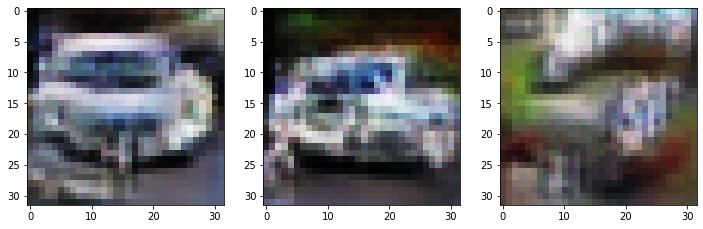

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5240 - g_loss: 1.2562
Epoch 46/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5157 - g_loss: 1.1717

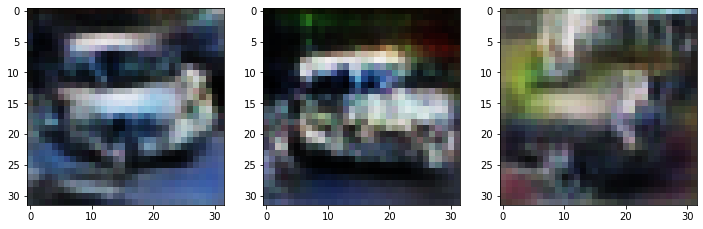

94/94 [==============================] - 5s 55ms/step - d_loss: 0.5158 - g_loss: 1.1777
Epoch 47/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5329 - g_loss: 1.1706

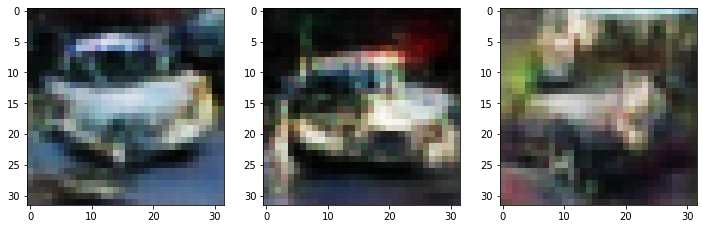

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5317 - g_loss: 1.1654
Epoch 48/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5562 - g_loss: 1.2608

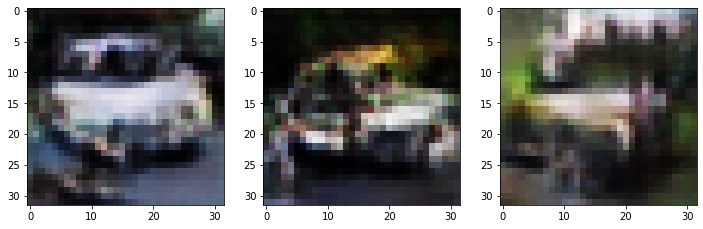

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5563 - g_loss: 1.2568
Epoch 49/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5258 - g_loss: 1.1540

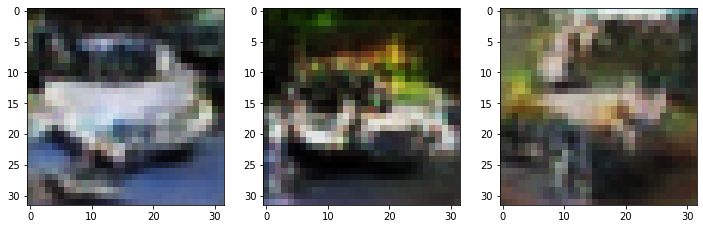

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5254 - g_loss: 1.1537
Epoch 50/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5295 - g_loss: 1.1435

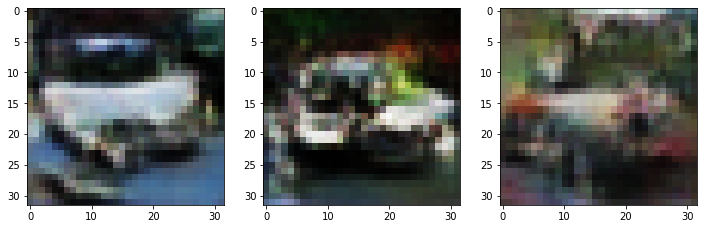

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5284 - g_loss: 1.1414
Epoch 51/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5400 - g_loss: 1.1443

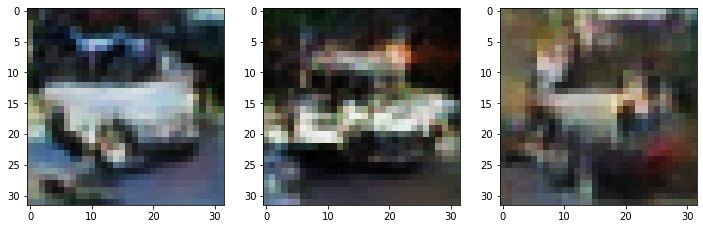

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5401 - g_loss: 1.1484
Epoch 52/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5472 - g_loss: 1.1710

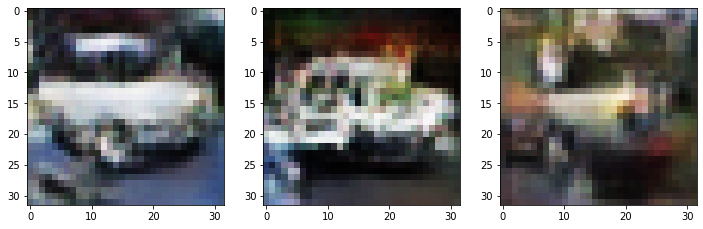

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5466 - g_loss: 1.1740
Epoch 53/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5438 - g_loss: 1.1097

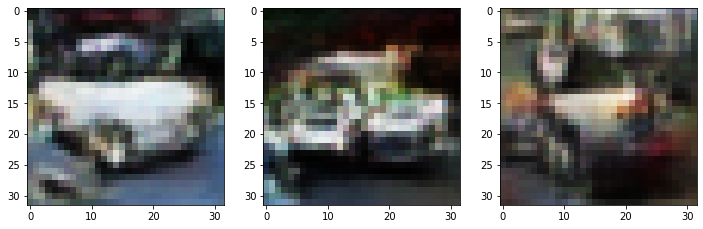

94/94 [==============================] - 5s 58ms/step - d_loss: 0.5433 - g_loss: 1.1082
Epoch 54/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5425 - g_loss: 1.1073

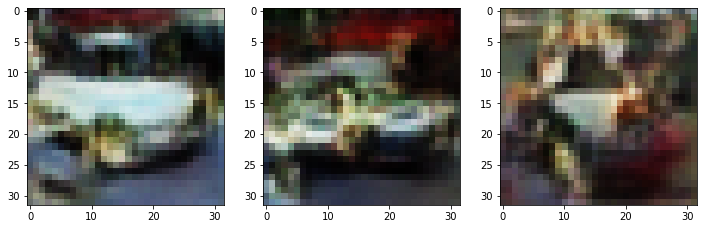

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5420 - g_loss: 1.1067
Epoch 55/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5548 - g_loss: 1.1786

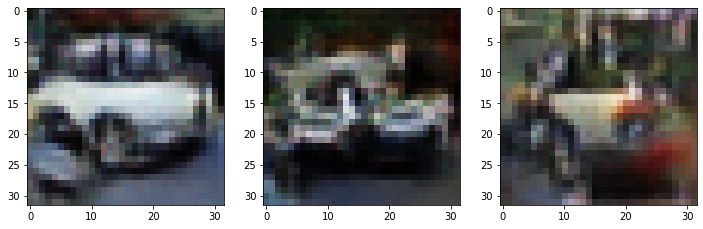

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5550 - g_loss: 1.1792
Epoch 56/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5526 - g_loss: 1.1302

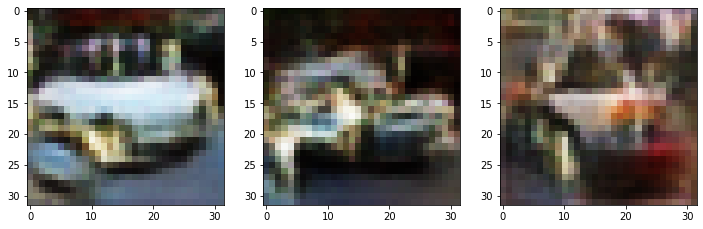

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5526 - g_loss: 1.1295
Epoch 57/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5428 - g_loss: 1.0863

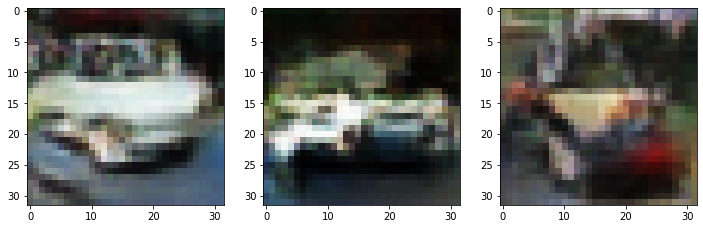

94/94 [==============================] - 5s 57ms/step - d_loss: 0.5414 - g_loss: 1.0851
Epoch 58/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5475 - g_loss: 1.2237

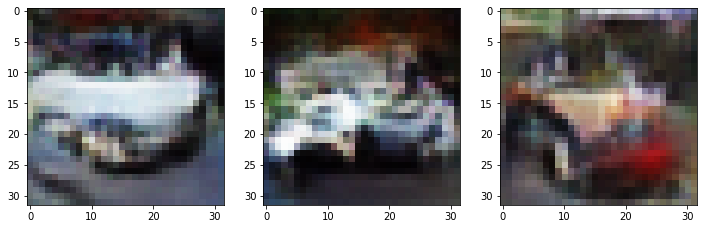

94/94 [==============================] - 5s 57ms/step - d_loss: 0.5486 - g_loss: 1.2280
Epoch 59/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5418 - g_loss: 1.1245

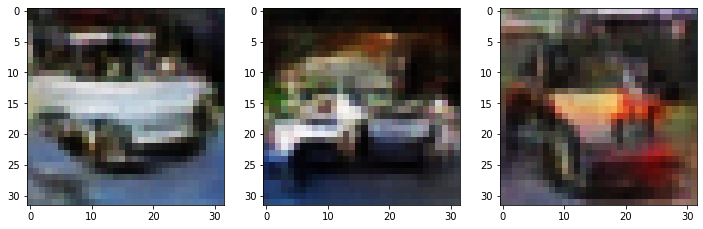

94/94 [==============================] - 5s 57ms/step - d_loss: 0.5409 - g_loss: 1.1245
Epoch 60/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5446 - g_loss: 1.1425

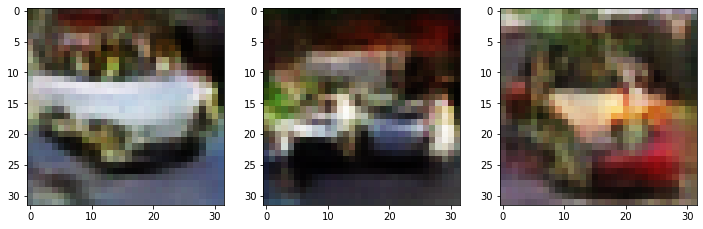

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5453 - g_loss: 1.1400
Epoch 61/100
94/94 [==============================] - ETA: 0s - d_loss: 0.5473 - g_loss: 1.0791

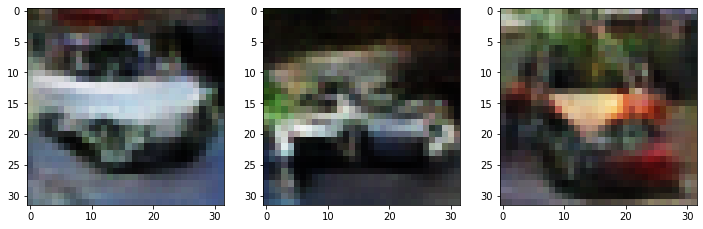

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5468 - g_loss: 1.0781
Epoch 62/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5507 - g_loss: 1.0952

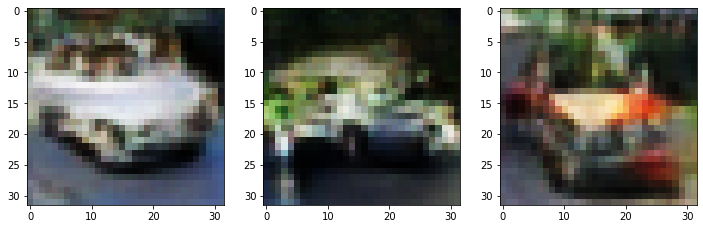

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5503 - g_loss: 1.0915
Epoch 63/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5471 - g_loss: 1.0767

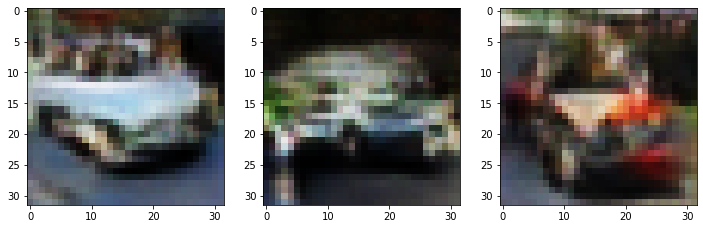

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5469 - g_loss: 1.0821
Epoch 64/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5557 - g_loss: 1.1018

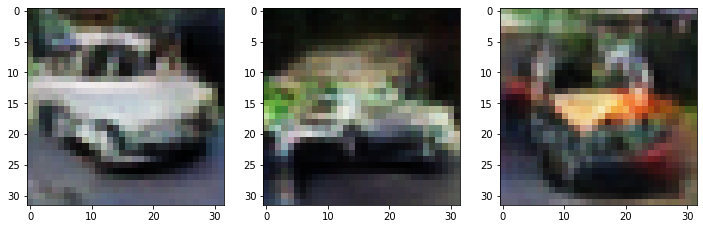

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5555 - g_loss: 1.1002
Epoch 65/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5539 - g_loss: 1.1056

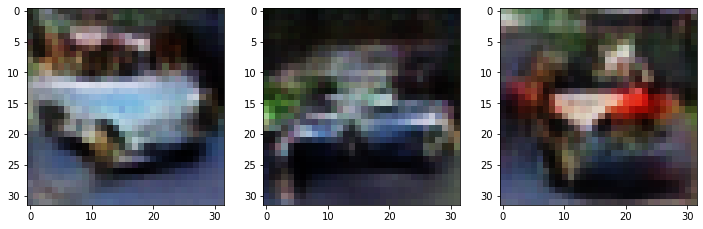

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5534 - g_loss: 1.1080
Epoch 66/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5521 - g_loss: 1.0764

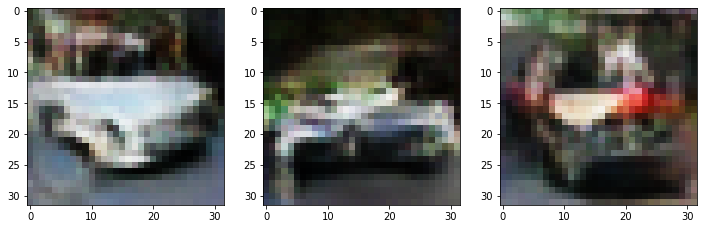

94/94 [==============================] - 5s 57ms/step - d_loss: 0.5517 - g_loss: 1.0726
Epoch 67/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5472 - g_loss: 1.0624

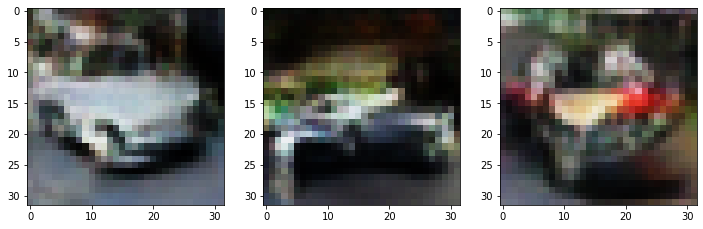

94/94 [==============================] - 6s 59ms/step - d_loss: 0.5460 - g_loss: 1.0605
Epoch 68/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5486 - g_loss: 1.1378

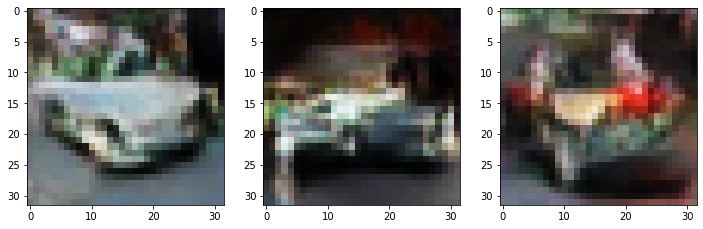

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5479 - g_loss: 1.1348
Epoch 69/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5513 - g_loss: 1.0952

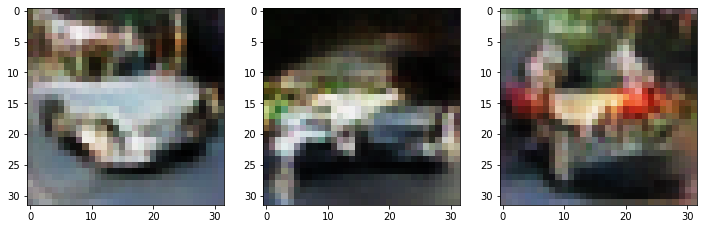

94/94 [==============================] - 5s 57ms/step - d_loss: 0.5505 - g_loss: 1.0871
Epoch 70/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5447 - g_loss: 1.0610

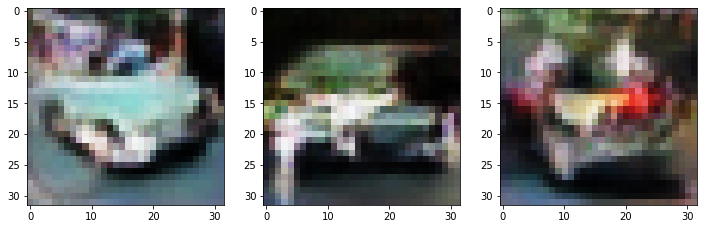

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5444 - g_loss: 1.0565
Epoch 71/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5516 - g_loss: 1.1284

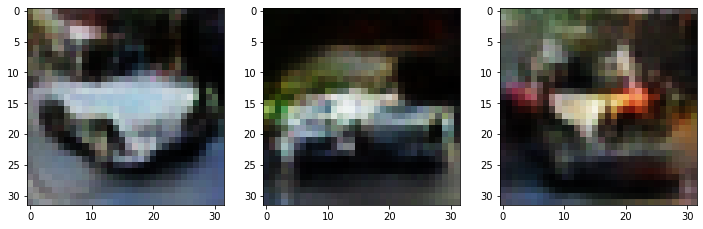

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5505 - g_loss: 1.1270
Epoch 72/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5386 - g_loss: 1.1116

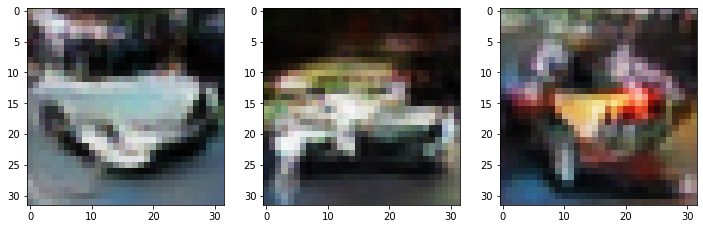

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5386 - g_loss: 1.1149
Epoch 73/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5374 - g_loss: 1.1522

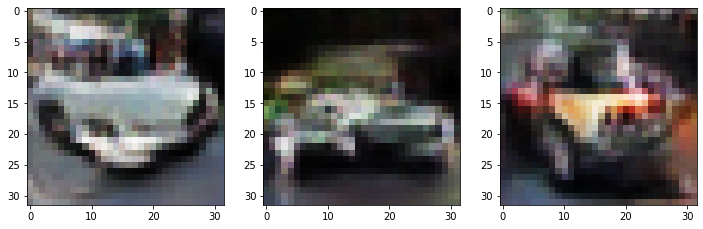

94/94 [==============================] - 5s 57ms/step - d_loss: 0.5379 - g_loss: 1.1536
Epoch 74/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5371 - g_loss: 1.0961

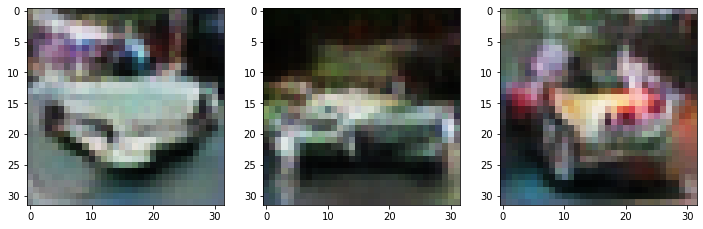

94/94 [==============================] - 5s 57ms/step - d_loss: 0.5375 - g_loss: 1.0939
Epoch 75/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5418 - g_loss: 1.1073

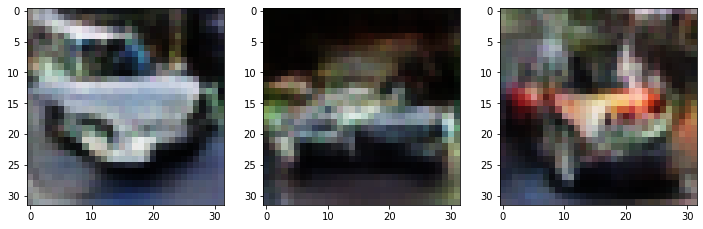

94/94 [==============================] - 5s 57ms/step - d_loss: 0.5418 - g_loss: 1.1136
Epoch 76/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5456 - g_loss: 1.0837

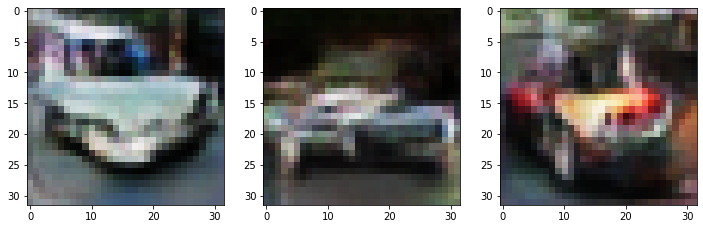

94/94 [==============================] - 5s 57ms/step - d_loss: 0.5445 - g_loss: 1.0851
Epoch 77/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5380 - g_loss: 1.1358

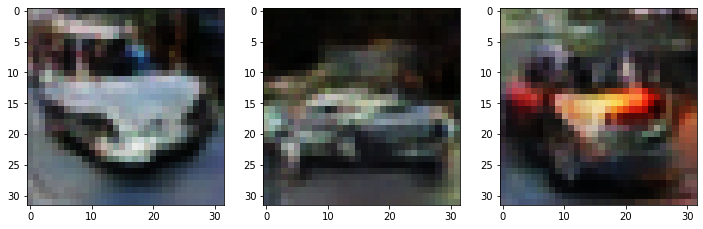

94/94 [==============================] - 5s 57ms/step - d_loss: 0.5373 - g_loss: 1.1342
Epoch 78/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5362 - g_loss: 1.1319

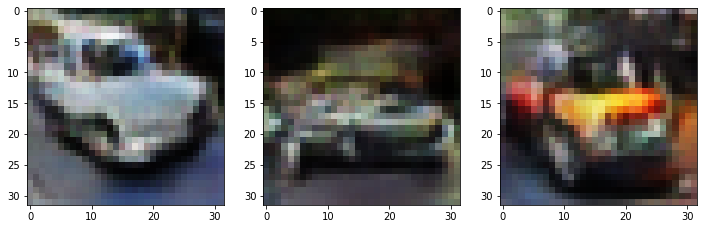

94/94 [==============================] - 5s 57ms/step - d_loss: 0.5353 - g_loss: 1.1359
Epoch 79/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5312 - g_loss: 1.1283

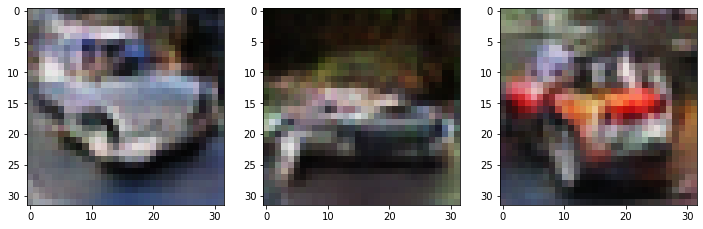

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5308 - g_loss: 1.1260
Epoch 80/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5374 - g_loss: 1.1316

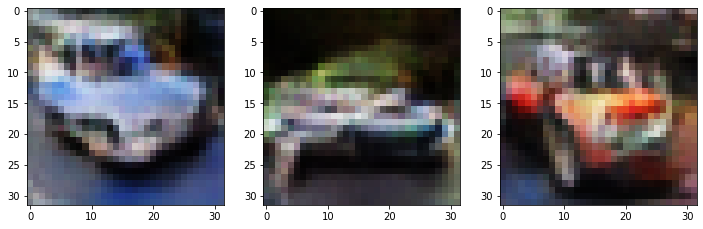

94/94 [==============================] - 5s 57ms/step - d_loss: 0.5377 - g_loss: 1.1320
Epoch 81/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5497 - g_loss: 1.1472

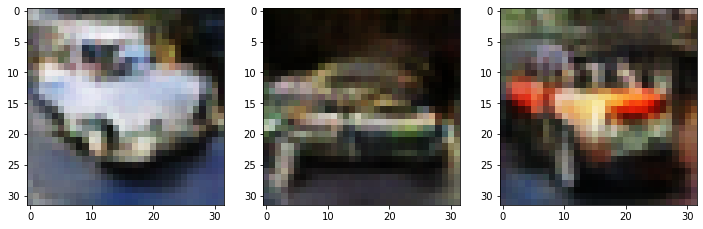

94/94 [==============================] - 5s 58ms/step - d_loss: 0.5499 - g_loss: 1.1467
Epoch 82/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5354 - g_loss: 1.1291

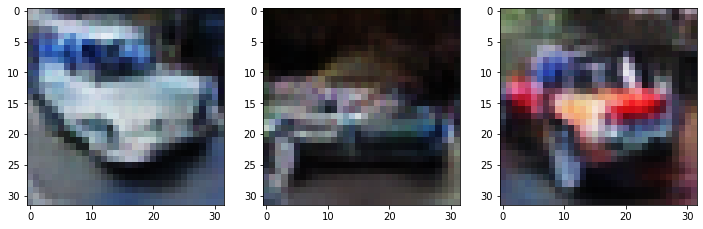

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5344 - g_loss: 1.1311
Epoch 83/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5290 - g_loss: 1.1190

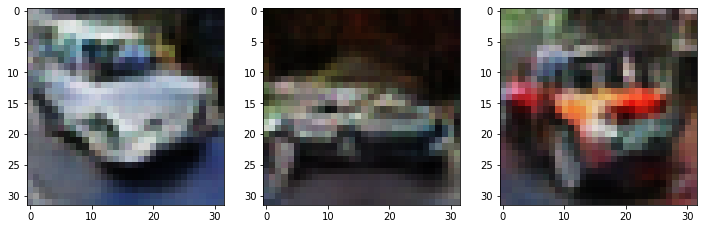

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5275 - g_loss: 1.1158
Epoch 84/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5312 - g_loss: 1.1258

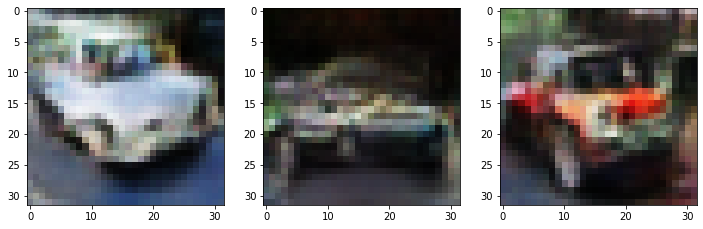

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5305 - g_loss: 1.1255
Epoch 85/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5284 - g_loss: 1.1355

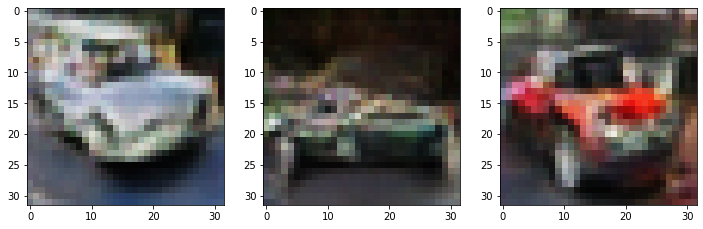

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5278 - g_loss: 1.1342
Epoch 86/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5297 - g_loss: 1.1208

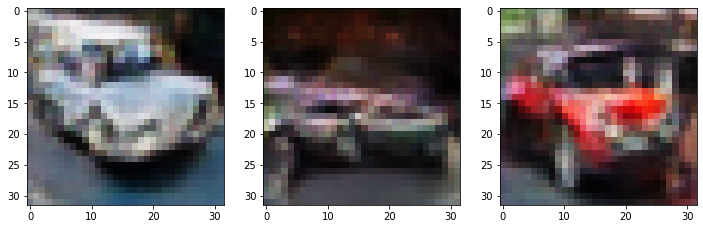

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5285 - g_loss: 1.1161
Epoch 87/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5313 - g_loss: 1.1293

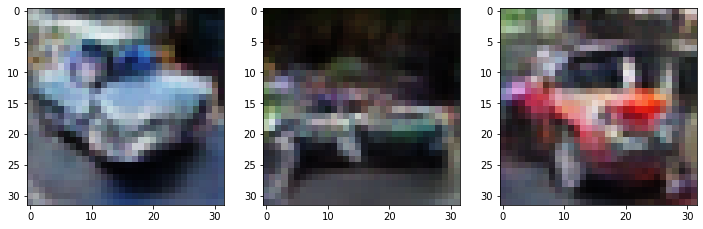

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5310 - g_loss: 1.1320
Epoch 88/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5294 - g_loss: 1.1441

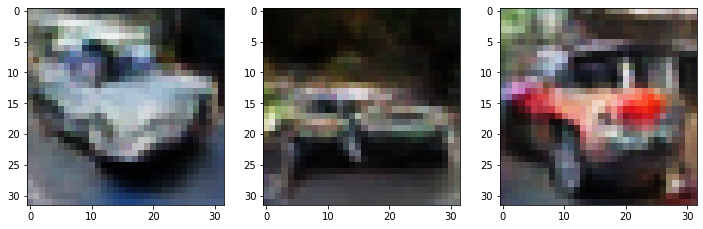

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5286 - g_loss: 1.1523
Epoch 89/100
94/94 [==============================] - ETA: 0s - d_loss: 0.5220 - g_loss: 1.1497

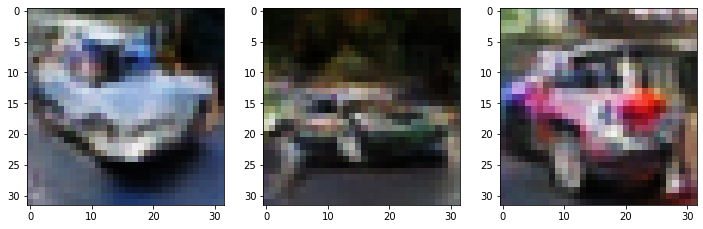

94/94 [==============================] - 5s 57ms/step - d_loss: 0.5217 - g_loss: 1.1483
Epoch 90/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5264 - g_loss: 1.1617

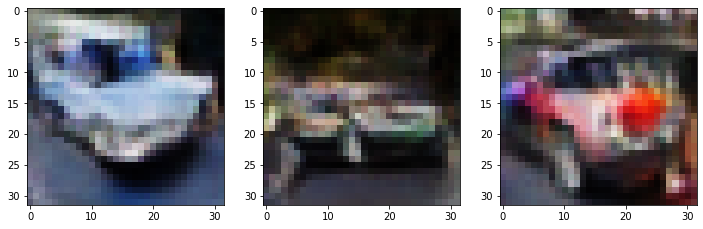

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5254 - g_loss: 1.1603
Epoch 91/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5204 - g_loss: 1.1681

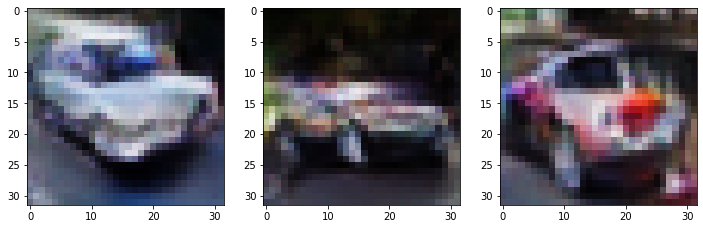

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5207 - g_loss: 1.1686
Epoch 92/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5205 - g_loss: 1.1455

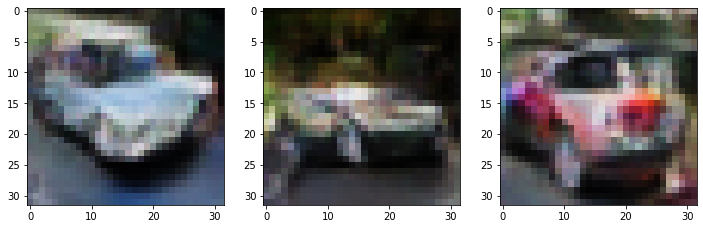

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5194 - g_loss: 1.1412
Epoch 93/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5176 - g_loss: 1.1597

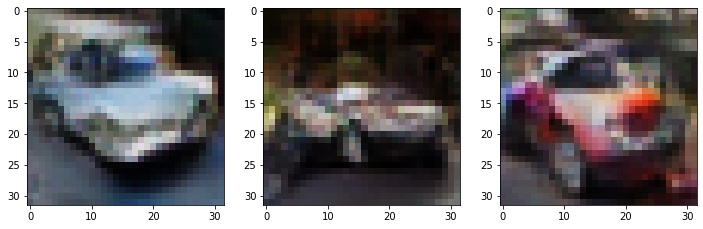

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5161 - g_loss: 1.1585
Epoch 94/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5176 - g_loss: 1.1712

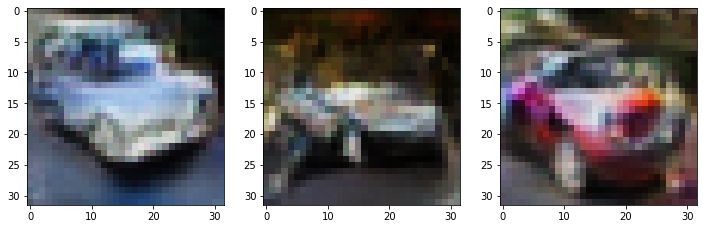

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5165 - g_loss: 1.1688
Epoch 95/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5112 - g_loss: 1.2066

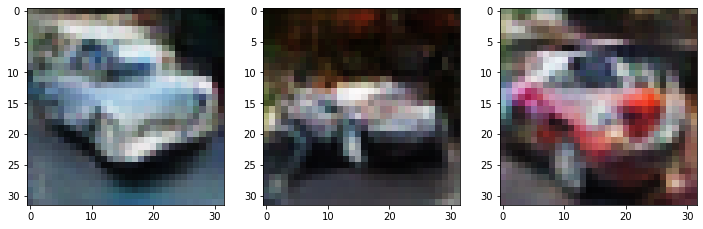

94/94 [==============================] - 5s 58ms/step - d_loss: 0.5105 - g_loss: 1.2066
Epoch 96/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5184 - g_loss: 1.1726

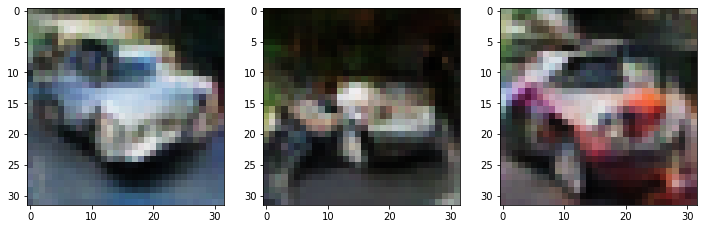

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5192 - g_loss: 1.1865
Epoch 97/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5241 - g_loss: 1.1928

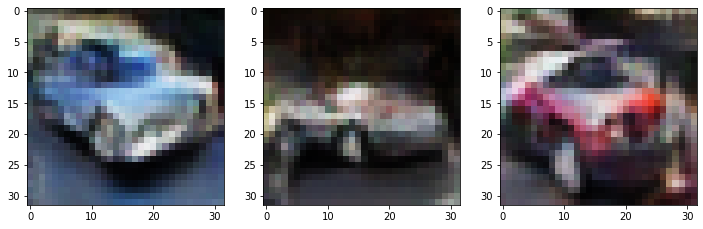

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5233 - g_loss: 1.1892
Epoch 98/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5193 - g_loss: 1.1863

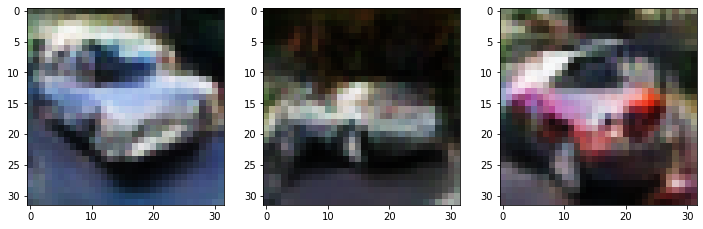

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5178 - g_loss: 1.1829
Epoch 99/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5124 - g_loss: 1.1793

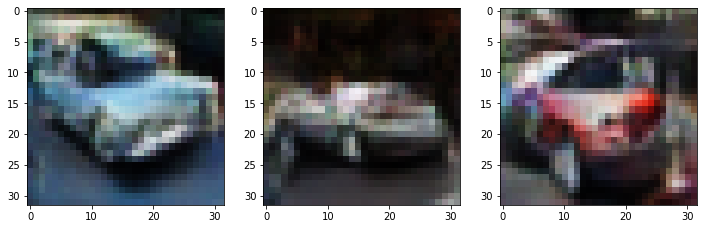

94/94 [==============================] - 5s 57ms/step - d_loss: 0.5118 - g_loss: 1.1791
Epoch 100/100
93/94 [============================>.] - ETA: 0s - d_loss: 0.5175 - g_loss: 1.2149

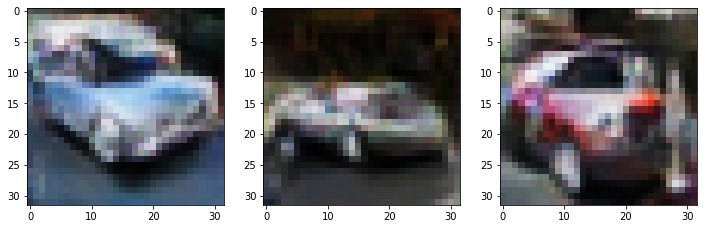

94/94 [==============================] - 5s 56ms/step - d_loss: 0.5165 - g_loss: 1.2179


In [ ]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    x_train, epochs=epochs, callbacks=[GANMonitor(latent_dims=test_latent_dims, num_img=num_img)]
)

По визуальному впечатлению, модель справилась с генерацией и сошлась за 100 эпох.

Посмотрим на пример сгенерированного изображения с помощью случайного 100-мерного латентного вектора.

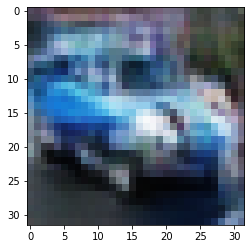

In [ ]:
vector = tf.random.normal(shape=(1,latent_dim))
plt.imshow((gan.generator(vector).numpy()[0] + 1) / 2)
plt.show()

Теперь попробуем изменить в этом векторе первые n параметров на отклонение bias и посмотреть, как меняется картинка.

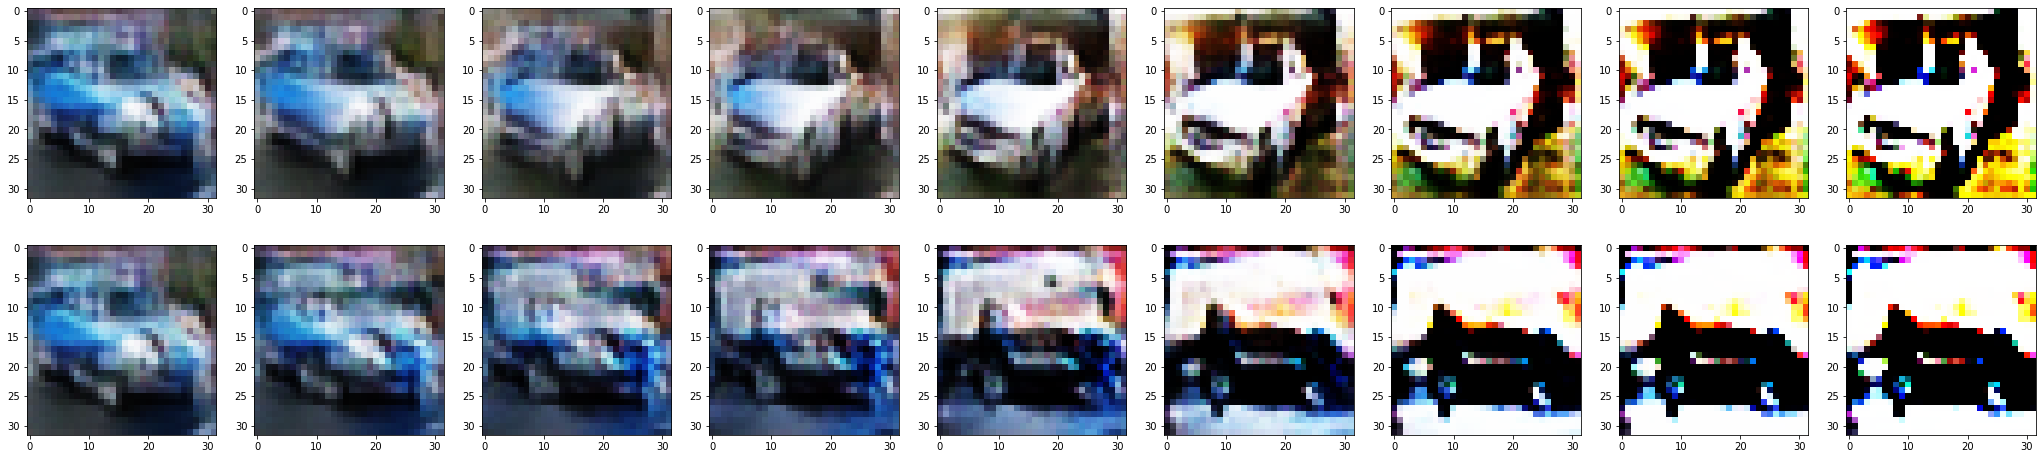

In [ ]:
first_parameters = 10
list_bias = [0, 1, 2, 3, 5, 10, 20, 30, 50]

plt.figure(figsize = (len(list_bias)*4, 2*4))
for i in range(len(list_bias)):
  plt.subplot(2,len(list_bias),i+1)
  new_vector = tf.unstack(vector[0])
  new_vector[0:first_parameters] = np.array(new_vector)[0:first_parameters] - list_bias[i]
  new_vector = tf.stack([new_vector])
  plt.imshow((gan.generator(new_vector).numpy()[0]+ 1) / 2)
for i in range(len(list_bias)):
  plt.subplot(2,len(list_bias),len(list_bias)+i+1)
  new_vector = tf.unstack(vector[0])
  new_vector[0:first_parameters] = np.array(new_vector)[0:first_parameters] + list_bias[i]
  new_vector = tf.stack([new_vector])
  plt.imshow((gan.generator(new_vector).numpy()[0]+ 1) / 2)
plt.show()

Видно, что: 

Малых отклонениях картинка слабо меняется.

При средних отклонениях машина уже меняется на столько, что получается другая, новая.

При больших отклонениях, мы сильно выходим за то нормальное распределение, на котором мы учили генератор, поэтому картинка начинает "выгорать" и перестаёт быть реалистичной.

## Вывод:

Я обучил генеративно-состязательную нейросеть (GAN) генерировать новые случайные rgb картинки 32*32 на которых изображены машины.

Для этого мне пришлось очень тонко и тщательно настраивать модель.

Чтобы модель начала сходится в самом начале, мне пришлось добавить шум к меткам сгенерированных изображений, при обучении discriminator.

Так же я подобрал параметр alpha=0.2 в слой преобразования данных LeakyReLU, параметры learning_rate=0.0002, beta_1=0.5 для опитимизатора Adam, размеры ядер и количество карт в слоях свёртки и транспонированной свёртки, размер латентного вектора latent_dim = 100, который определяет сгенерированные изобразжения и подобрал ещё многое другое.

А так же я проанализировал, как зависят параметры латентного вектора на генерируемое изображение и описал результат.

## 2) Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на курсе.

### CGAN

Conditional Generative Adversarial Networks (CGAN) очень похож на обычный GAN.

В обычном GAN у нас генерируются случаные похожие изображения. 

CGAN же генерируются похожие изображения для определенных классов. Тоесть мы можем учиться генерировать изображения машин и кораблей одновременно, а потом генерировать только машины.

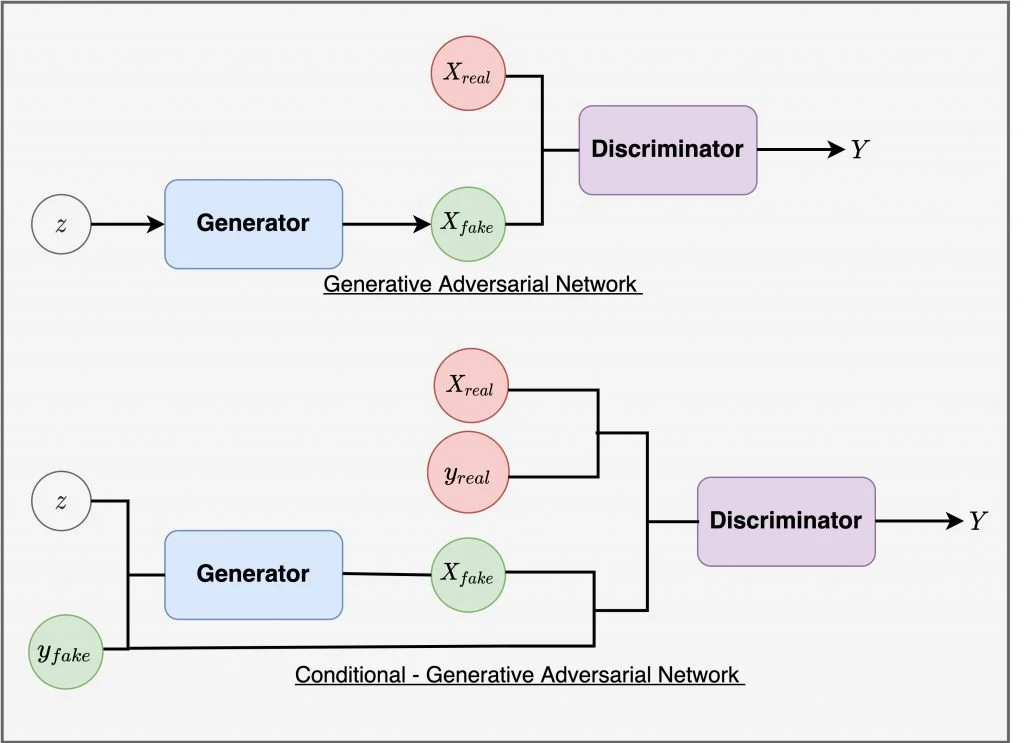

Для этого на вход дискриминатора мы должны добавить нашему изображения столько каналов, каков размер вектора определяющий класс изображения.

Например в MNIST чтобы добавить классы от 0 до 9, нам хватит одномерного вектора, значит нам нужно добавить 1 канал к входному изображению. Например если изображение 28х28х1 и мы хотим добавить метку класса 0, то к исходному изображения нужно присоединить матрицу 28х28х1 состоящую из 0. Таким образом получиться тензор 28х28х2, с двумя каналами.

На вход генератора подаётся вектор, состоящий из латентного вектора и метки класса.

Таким образом дискриматор понимает, как должен выглядеть каждый класс. А генератор, обучаясь, начинает понимать, какое изображение ждёт дискриматор, в зависимости от последней цифры латентного слоя.

Таким образом мы можем генерировать изображения определенных классов.